## Github Analysis notebook
This notebook contains scripts to process github experiment results and plot them out (for single-threaded run)

In [1]:
import pandas as pd
import json
import zipfile

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

In [2]:
experimental_zip_path = '../results-general-dict.zip'

In [3]:
# load logic + pre-processing
def extract_per_file_stats_tuplex(job_stats):
        n_requests = len(job_stats['responses'])
        L =  [job_stats['responses'][i]['stats'] for i in range(n_requests)]
        for i in range(n_requests):
            req_uri = job_stats['responses'][i]['request'][0]
            L[i]['input_path'] = req_uri[:req_uri.rfind(':')]
            L[i]['req_uri'] = req_uri
            L[i]['duration'] = L[i]['request_total_time']
            L[i]['num_input_rows'] = L[i]['input']['total_input_row_count']
            L[i]['num_output_rows'] = L[i]['output']['normal']
        return L

def load_tuplex_path(fp, path):
    lines = fp.readlines()
    rows = [json.loads(line) for line in lines]

    data = []
    for row in rows:
        if 'python-baseline' not in path:
            ans = {'benchmark': 'github'}
            for k in ['benchmark', 'input_path', 'job_time_in_s', 'metrics', 'mode', 'options', 'output_path', 'scratch_path', 'startup_time_in_s']:
                ans[k] = row.get(k)
            try:
                ans['per_file_stats'] = extract_per_file_stats_tuplex(row['detailed_job_stats'])
            except:
                print(f'--- ERR: extract failed for path {path}')
            ans['llvm'] = 16 if 'llvm16' in path else 9
            row = ans
        data.append(row)
    return pd.DataFrame(data)

def load_tuplex_runs(zf):
    df_tplx = pd.DataFrame()
    for path in filter(lambda name: name.endswith('.ndjson'), zf.namelist()):
        print(f'loading {path}')
        df_tplx = pd.concat((df_tplx, load_tuplex_path(zf.open(path), path)))
    return df_tplx
        
def load_cc_baselines(zf):
    df_cc = pd.DataFrame()
    # the C++ baseline are directly stored as csv
    for path in filter(lambda name: name.endswith('.csv'), zf.namelist()):
        print(f'loading {path}')
        df_cc = pd.concat((df_cc, pd.read_csv(zf.open(path))))
    df_cc = df_cc[df_cc['mode'] != 'mode']

    for name in ['time_in_s', 'loading_time_in_s', 'total_time_in_s']:
        df_cc[name] = df_cc[name].astype(float)
    for name in ['input_row_count', 'output_row_count']:
        df_cc[name] = df_cc[name].astype(int)
    return df_cc

with zipfile.ZipFile(experimental_zip_path, 'r') as zf:
    # print(zf.namelist())
    df_cc = load_cc_baselines(zf)
   
    df_tplx = load_tuplex_runs(zf)
    
#     with myzip.open('document.txt') as myfile:
#         print(myfile.read())

loading results-general-dict/local-exp-llvm16/c++-baseline/github/best_results.csv
loading results-general-dict/local-exp-llvm16/c++-baseline/github/cjson_results.csv
loading results-general-dict/local-exp-llvm16/c++-baseline/github/yyjson_results.csv
loading results-general-dict/local-exp-llvm16/c++-baseline/github/cstruct_results.csv
loading results-general-dict/local-exp-llvm9/tuplex/github/hyper/results.ndjson
loading results-general-dict/local-exp-llvm9/tuplex/github/hyper-noopt/results.ndjson
loading results-general-dict/local-exp-llvm9/tuplex/github/nohyper/results.ndjson
loading results-general-dict/local-exp-llvm9/python-baseline/github/results.ndjson
loading results-general-dict/local-exp-llvm16/tuplex/github/hyper/results.ndjson
loading results-general-dict/local-exp-llvm16/tuplex/github/hyper-noopt/results.ndjson
loading results-general-dict/local-exp-llvm16/tuplex/github/nohyper/results.ndjson
loading results-general-dict/local-exp-llvm16/python-baseline/github/results.ndj

In [22]:
df_cc.head()

,mode,input_path,output_path,time_in_s,loading_time_in_s,total_time_in_s,input_row_count,output_row_count
0,best,/hot/data/github_daily/2011-10-15.json,./local-exp/c++-baseline/github/best/output/pa...,0.060073,0.020326,21.77326,48899,1418
1,best,/hot/data/github_daily/2012-10-15.json,./local-exp/c++-baseline/github/best/output/pa...,0.193989,0.051573,21.77326,165692,5907
2,best,/hot/data/github_daily/2013-10-15.json,./local-exp/c++-baseline/github/best/output/pa...,0.411413,0.130098,21.77326,296456,10628
3,best,/hot/data/github_daily/2014-10-15.json,./local-exp/c++-baseline/github/best/output/pa...,1.542250,0.621012,21.77326,476393,16014
4,best,/hot/data/github_daily/2015-10-15.json,./local-exp/c++-baseline/github/best/output/pa...,1.385090,0.521614,21.77326,737714,25301


In [5]:
df_tplx = df_tplx.reset_index().rename(columns={'index':'run', 'job_time_in_s':'total_time_in_s'})
df_tplx['run'] = df_tplx['run'] + 1
df_tplx.head()

,run,benchmark,input_path,total_time_in_s,metrics,mode,options,output_path,scratch_path,startup_time_in_s,per_file_stats,llvm,total_input_paths_size_in_bytes,total_input_rows,total_output_rows
0,1,github,/hot/data/github_daily/*.json,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex,"{'tuplex.allowUndefinedBehavior': False, 'tupl...",./local-exp/tuplex/github/hyper/output,./local-exp/scratch,0.019958,"[{'hyper_active': True, 'input': {'fallback': ...",9.0,NaN,NaN,NaN
1,2,github,/hot/data/github_daily/*.json,169.666286,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex,"{'tuplex.allowUndefinedBehavior': False, 'tupl...",./local-exp/tuplex/github/hyper/output,./local-exp/scratch,0.020359,"[{'hyper_active': True, 'input': {'fallback': ...",9.0,NaN,NaN,NaN
2,3,github,/hot/data/github_daily/*.json,170.050273,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex,"{'tuplex.allowUndefinedBehavior': False, 'tupl...",./local-exp/tuplex/github/hyper/output,./local-exp/scratch,0.020020,"[{'hyper_active': True, 'input': {'fallback': ...",9.0,NaN,NaN,NaN
3,4,github,/hot/data/github_daily/*.json,171.278456,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex,"{'tuplex.allowUndefinedBehavior': False, 'tupl...",./local-exp/tuplex/github/hyper/output,./local-exp/scratch,0.020803,"[{'hyper_active': True, 'input': {'fallback': ...",9.0,NaN,NaN,NaN
4,1,github,/hot/data/github_daily/*.json,170.569332,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex,"{'tuplex.allowUndefinedBehavior': False, 'tupl...",./local-exp/tuplex/github/hyper-noopt/output,./local-exp/scratch,0.020239,"[{'hyper_active': True, 'input': {'fallback': ...",9.0,NaN,NaN,NaN


In [6]:
# expand per_file_stats in df
def preprocess_tplx_df(df_tplx):
    df = df_tplx.copy()
    #df = df.dropna()
    df.drop(columns='input_path', inplace=True)
    columns_to_keep = ['run', 'benchmark', 'input_path',
                           'total_time_in_s', 'mode', 'output_path', 'startup_time_in_s']
    df = df.explode('per_file_stats')
    df.reset_index(drop=True, inplace=True)
    
    def expand_helper(t):
        if pd.isna(t) or t is None:
            return pd.Series()
        # example looks like this
        # {'hyper_active': True,
        #   'input': {'fallback': 0,
        #    'general': 0,
        #    'input_file_count': 1,
        #    'normal': 48899,
        #    'total_input_row_count': 48899,
        #    'unresolved': 0},
        #   'output': {'except': 0, 'normal': 1418},
        #   'request_total_time': 0.743892436,
        #   'spills': {'count': 0, 'size': 0},
        #   'timings': {'compile_time': 0.0298965,
        #    'fast_path_execution_time': 0.413112,
        #    'general_and_interpreter_time': 4.3911e-05,
        #    'hyperspecialization_time': 0.279614},
        #   'input_path': '/hot/data/github_daily/2011-10-15.json',
        #   'req_uri': '/hot/data/github_daily/2011-10-15.json:0-78478920',
        #   'duration': 0.743892436,
        #   'num_input_rows': 48899,
        #   'num_output_rows': 1418}
        data = {'input_row_count': t['num_input_rows'],
                'output_row_count': t['num_output_rows'],
                'time_in_s': t['duration'],
                'input_path': t['input_path']
               }
        if t.get('hyper_active') is not None:
            more_data = {'hyper': t.get('hyper_active'),
                    'request_time_in_s': t['request_total_time'],
                    'compile_time_in_s': t['timings']['compile_time'],
                    'fast_path_execution_time_in_s':t['timings']['fast_path_execution_time'],
                    'general_and_interpreter_time_in_s':t['timings']['general_and_interpreter_time'],
                    'hyperspecialization_time':t['timings'].get('hyperspecialization_time'),}
            data.update(more_data)
        
        return pd.Series(list(data.values()), index=(data.keys()))
    df = pd.merge(df, df['per_file_stats'].apply(expand_helper), left_index=True, right_index=True)
    df.drop(columns=['options', 'scratch_path'], inplace=True)
    
    def adjust_mode(row):
        mode = row['mode']
        op = row['output_path']
        llvm = row['llvm']
        if './local-exp/tuplex/github/' in op:
            return f'tuplex-llvm{int(llvm)}-' + op.replace('./local-exp/tuplex/github/', '').replace('/output', '')
        elif 'python-baseline' in op:
            return 'python'
        else:
            return mode
    df['mode'] = df[['mode', 'output_path', 'llvm']].apply(adjust_mode, axis=1)
    
    return df

In [7]:
df = preprocess_tplx_df(df_tplx)

In [8]:
df.head()

,run,benchmark,total_time_in_s,metrics,mode,output_path,startup_time_in_s,per_file_stats,llvm,total_input_paths_size_in_bytes,...,input_row_count,output_row_count,time_in_s,input_path,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time
0,1,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 0...",9.0,NaN,...,48899,1418,0.743892,/hot/data/github_daily/2011-10-15.json,True,0.743892,0.029896,0.413112,0.000044,0.279614
1,1,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 8...",9.0,NaN,...,165692,5907,1.792307,/hot/data/github_daily/2012-10-15.json,True,1.792307,0.022970,1.351070,0.127788,0.272553
2,1,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 1...",9.0,NaN,...,296456,10628,3.366036,/hot/data/github_daily/2013-10-15.json,True,3.366036,0.023286,2.882480,0.192423,0.249389
3,1,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 1...",9.0,NaN,...,476393,16014,10.867659,/hot/data/github_daily/2014-10-15.json,True,10.867659,0.020366,10.561600,0.037634,0.229411
4,1,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 0...",9.0,NaN,...,737714,25301,9.942523,/hot/data/github_daily/2015-10-15.json,True,9.942523,0.029784,9.623150,0.000050,0.270989


In [9]:
# merge cc and tuplex together
df = pd.concat((df, df_cc))

In [10]:
df.head()

,run,benchmark,total_time_in_s,metrics,mode,output_path,startup_time_in_s,per_file_stats,llvm,total_input_paths_size_in_bytes,...,output_row_count,time_in_s,input_path,hyper,request_time_in_s,compile_time_in_s,fast_path_execution_time_in_s,general_and_interpreter_time_in_s,hyperspecialization_time,loading_time_in_s
0,1.0,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 0...",9.0,NaN,...,1418,0.743892,/hot/data/github_daily/2011-10-15.json,True,0.743892,0.029896,0.413112,0.000044,0.279614,NaN
1,1.0,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 8...",9.0,NaN,...,5907,1.792307,/hot/data/github_daily/2012-10-15.json,True,1.792307,0.022970,1.351070,0.127788,0.272553,NaN
2,1.0,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 1...",9.0,NaN,...,10628,3.366036,/hot/data/github_daily/2013-10-15.json,True,3.366036,0.023286,2.882480,0.192423,0.249389,NaN
3,1.0,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 1...",9.0,NaN,...,16014,10.867659,/hot/data/github_daily/2014-10-15.json,True,10.867659,0.020366,10.561600,0.037634,0.229411,NaN
4,1.0,github,171.377957,"{'generate_llvm_time_s': 0, 'llvm_compilation_...",tuplex-llvm9-hyper,./local-exp/tuplex/github/hyper/output,0.019958,"{'hyper_active': True, 'input': {'fallback': 0...",9.0,NaN,...,25301,9.942523,/hot/data/github_daily/2015-10-15.json,True,9.942523,0.029784,9.623150,0.000050,0.270989,NaN


## Overall time
Aggregated by mode

In [11]:
def plot_total_time(df, normalize_to_best=False):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    if normalize_to_best:
        best_mean = df[df['mode'] == 'best']['total_time_in_s'].mean()
        df['total_time_in_s'] = df['total_time_in_s'] / best_mean
    
    sns.barplot(data=df.sort_values(by='total_time_in_s'), x='mode', y='total_time_in_s', capsize=.2)
    plt.xticks(rotation=90)
    
    if not normalize_to_best:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('total time')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

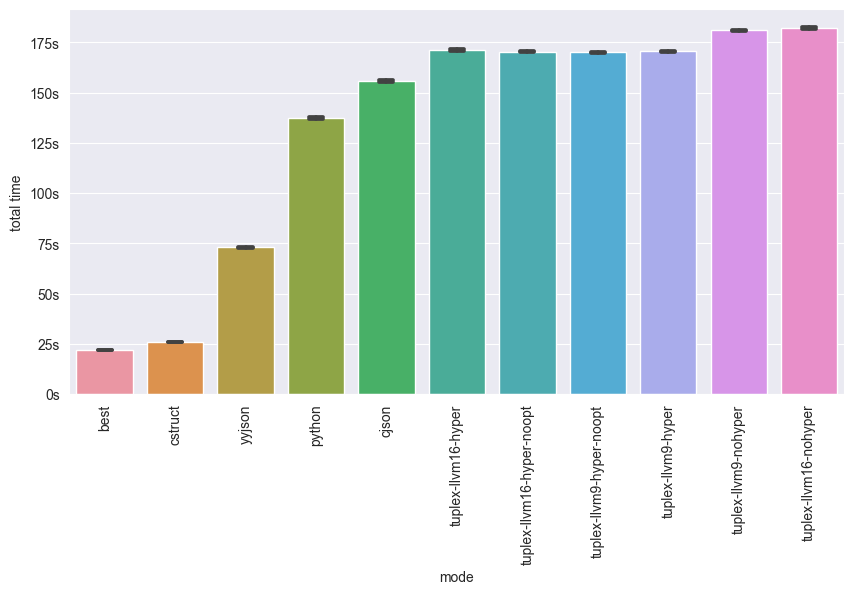

In [12]:
plot_total_time(df)

Speed relative to baseline, higher is slower.

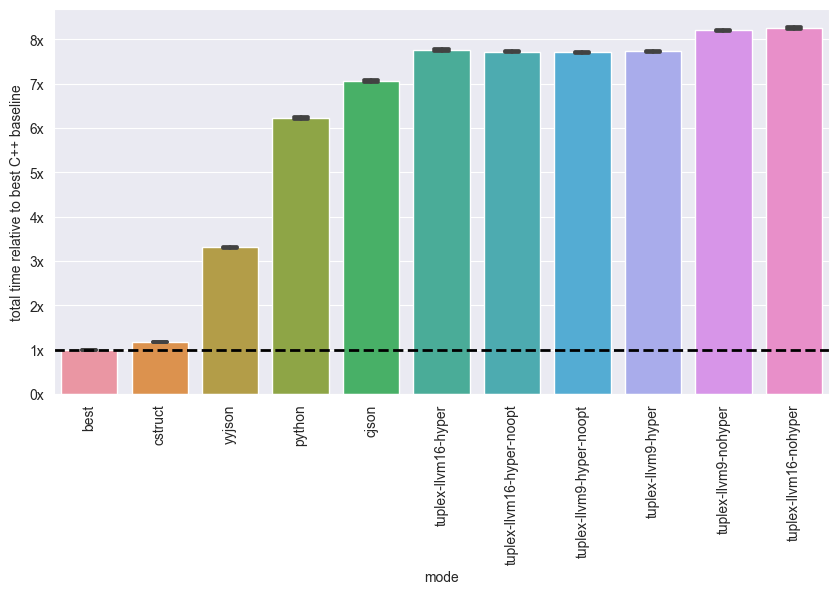

In [13]:
plot_total_time(df, normalize_to_best=True)

## Per file runtimes

In [14]:
def plot_per_file_runtimes(df, modes=['best', 'python', 'cjson', 'tuplex-llvm16-hyper', 'tuplex-llvm16-nohyper'], normalize_to_best=False):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    
    df = df[df['mode'].isin(modes)]
    import os
    df['input_path'] = df['input_path'].apply(os.path.basename)
    
    if normalize_to_best:
        def helper(g):
            g['time_factor_compared_to_best'] = g['time_in_s'] / g[g['mode'] == 'best']['time_in_s'].mean()
            return g
        df = df.groupby(['input_path'], group_keys=False).apply(helper)
    
    sns.barplot(df.sort_values(by=['time_in_s']), x='input_path',
                y='time_factor_compared_to_best' if normalize_to_best else 'time_in_s',
                hue='mode', errorbar=None, capsize=0)
    plt.xticks(rotation=90)
    
    if not normalize_to_best:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
        plt.ylabel('time per file')
    else:
        plt.axhline(1, lw=2, linestyle='--', color='k')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}x'))
        plt.ylabel('total time relative to best C++ baseline')

Comparing C++ baseline vs. python vs. cjson vs. Tuplex (in generic dict mode)

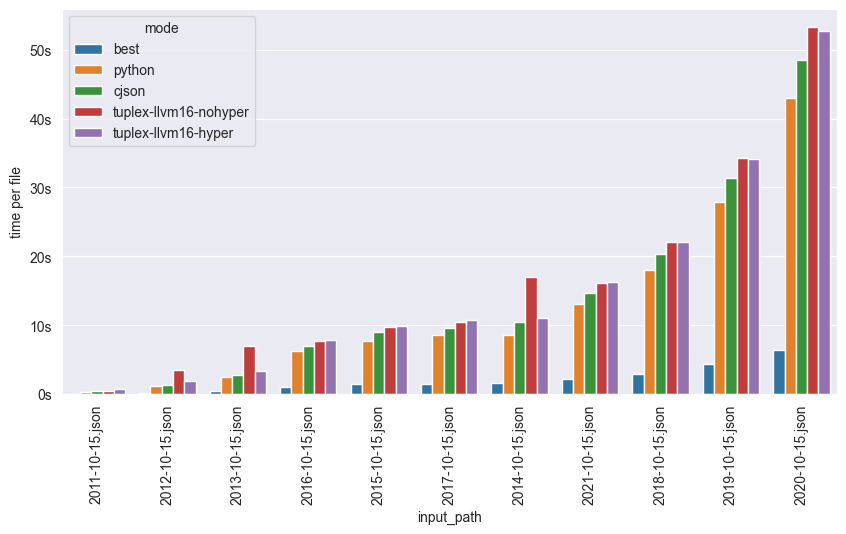

In [15]:
plot_per_file_runtimes(df)

Normalized to C++ baseline (best)

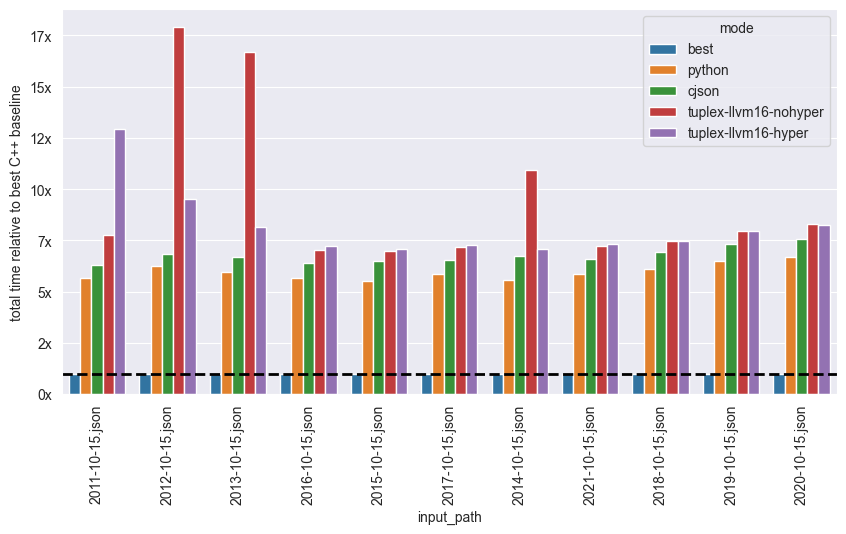

In [16]:
plot_per_file_runtimes(df, normalize_to_best=True)

C++ modes compared to best baseline (normalized)

(0.0, 9.0)

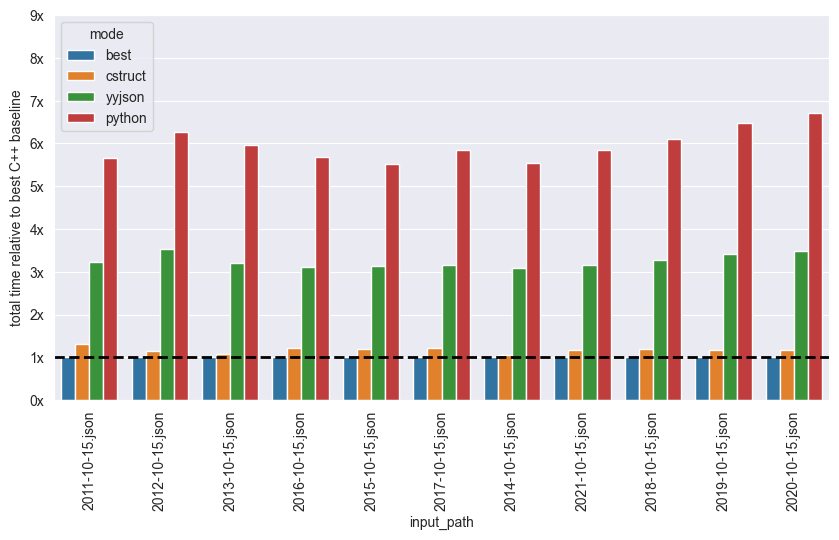

In [17]:
plot_per_file_runtimes(df, modes=['best', 'cstruct', 'yyjson', 'python'], normalize_to_best=True)
plt.ylim(0, 9)

## Breakdown of Tuplex mode

--> in generic dict mode, fast path is close to total duration.

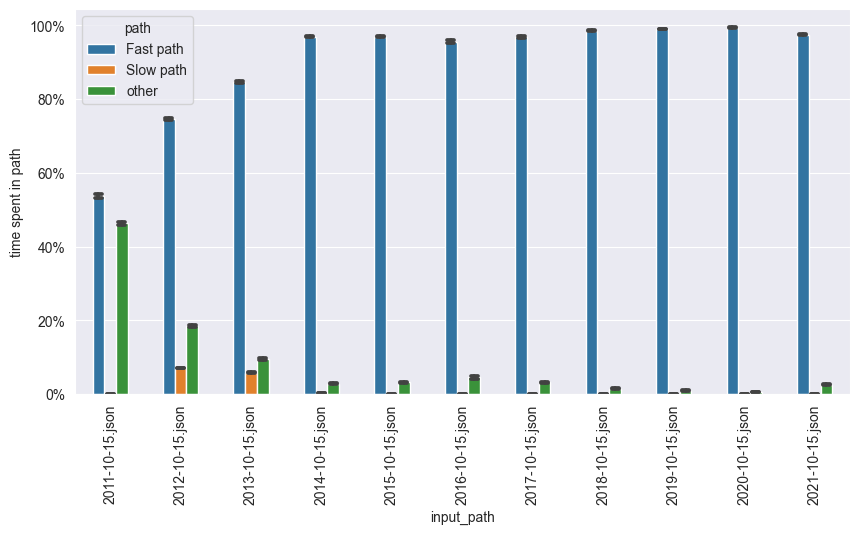

In [18]:
def plot_tplx_mode_path_breakdown_per_file(df, mode='tuplex-llvm16-hyper'):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    df = df[df['mode'] == mode]
    
    import os
    df['input_path'] = df['input_path'].apply(os.path.basename)
    
    columns = df.columns
    
    df['pct_fast_path'] = df['fast_path_execution_time_in_s'] / df['time_in_s']
    df['pct_slow_path'] = df['general_and_interpreter_time_in_s'] / df['time_in_s']
    df['pct_other'] = 1.0 - df['pct_fast_path'] - df['pct_slow_path']
    
    df = pd.melt(df, id_vars=columns, value_vars=['pct_fast_path', 'pct_slow_path', 'pct_other'],
        var_name='path', value_name='time_spent_in_path')
    def rename_path(p):
        d = {'pct_fast_path': 'Fast path',
            'pct_slow_path': 'Slow path',
            'pct_other': 'other'}
        return d[p]
    df['path'] =df['path'].apply(rename_path)
    
    sns.barplot(ax=ax, data=df, x='input_path',
                y='time_spent_in_path', hue='path', capsize=.1, width=.5)
    
    from matplotlib.ticker import PercentFormatter
    
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    plt.ylabel('time spent in path')
    plt.xticks(rotation=90)
plot_tplx_mode_path_breakdown_per_file(df)

In [19]:
def plot_tplx_mode_breakdown_per_file(df, mode='tuplex-llvm16-hyper', include_total_and_fast=False):
    df = df.copy()
    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    df = df[df['mode'] == mode]
    
    import os
    df['input_path'] = df['input_path'].apply(os.path.basename)
    
    colors = sns.color_palette()
    sns.set_palette(sns.color_palette('Set1'))
    sns.set_style('darkgrid')
    cs = .2
    
    if include_total_and_fast:
        # These will plot mostly total + fast path
        sns.pointplot(ax=ax, data=df, x="input_path", y="time_in_s", dodge=True, color='.5')

        sns.pointplot(ax=ax, data=df, x="input_path", y="fast_path_execution_time_in_s",
                      markers=['x'], color=colors[3])

    sns.pointplot(ax=ax, data=df, x="input_path", y="compile_time_in_s", capsize=cs, color=colors[0])
    sns.pointplot(ax=ax, data=df, x="input_path", y="general_and_interpreter_time_in_s", capsize=cs, color=colors[1])
    sns.pointplot(ax=ax, data=df, x="input_path", y="hyperspecialization_time", capsize=cs, color=colors[2])
    
    import matplotlib.patches as mpatches
    lgd_handles=[]
    if include_total_and_fast:
        lgd_handles += [mpatches.Patch(color='.5', label='total time'),
                mpatches.Patch(color=colors[3], label='fast path time')]
    lgd_handles+=[mpatches.Patch(color=colors[0], label='compile time'),
                mpatches.Patch(color=colors[1], label='general and interpreter time'),
                mpatches.Patch(color=colors[2], label='hyperspecialization time')]
    plt.legend(handles=lgd_handles)
    
    if include_total_and_fast:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}s'))
    else:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x*1000)}ms'))


    plt.ylabel('time per file')
    
    plt.xticks(rotation=90)

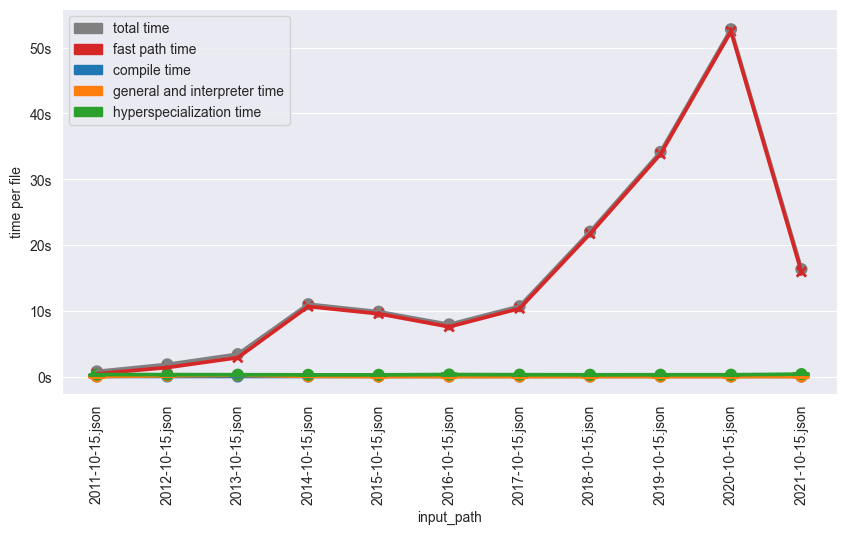

In [20]:
plot_tplx_mode_breakdown_per_file(df, include_total_and_fast=True)

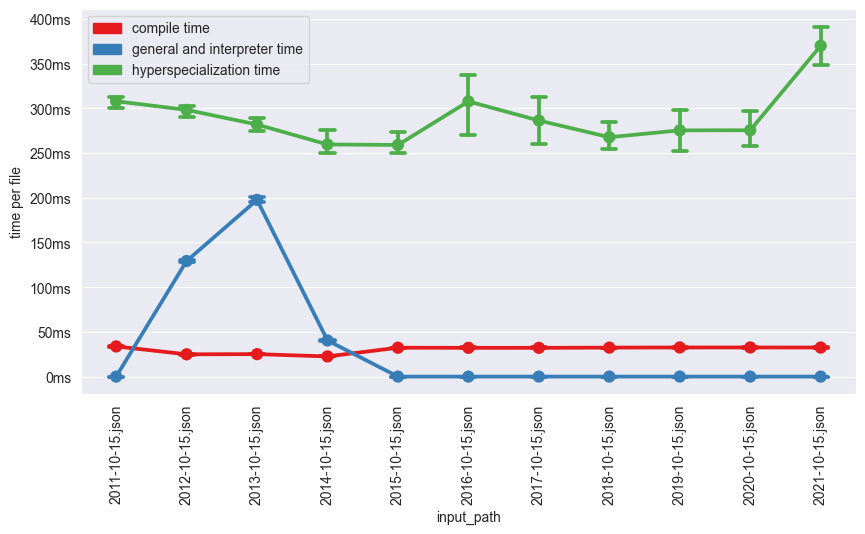

In [21]:
plot_tplx_mode_breakdown_per_file(df, include_total_and_fast=False)